In [84]:
import pickle
import pandas as pd
import os
import git
import numpy as np
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
## keras

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/akshay.uppal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/akshay.uppal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
## Read the labelled files and the poly_user
def get_git_root(path):
	git_repo = git.Repo(path, search_parent_directories=True)
	git_root = git_repo.git.rev_parse("--show-toplevel")
	return git_root

In [4]:
top_dir = os.path.join(get_git_root(os.getcwd()))
model_dir = os.path.join(get_git_root(os.getcwd()),"models")
input_dir = os.path.join(get_git_root(os.getcwd()),"input")
poly_dir = os.path.join(model_dir,"poly_users")
embeddings_dir = os.path.join(input_dir,"embeddings")
poly_users = pickle.load(open(os.path.join(poly_dir,"poly_users.pkl"),"rb"))
regular_users = pickle.load(open(os.path.join(poly_dir,"regular_users.pkl"),"rb"))
mono_users = pickle.load(open(os.path.join(poly_dir,"mono_users.pkl"),"rb"))

In [85]:
## insert the escalation dir
sys.path.insert(0, os.path.join(top_dir,"src","preprocess","escalation"))

In [86]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
import util
import driver
import preprocessing

In [11]:
## input data :juul_data 
juul_data = pd.read_csv(os.path.join(input_dir,"juul_data.csv"),lineterminator="\n")
juul_data["tweetCreatedAt"] = pd.to_datetime(juul_data["tweetCreatedAt"])
juul_data = juul_data.loc[juul_data.userID.isin(regular_users)]

# ## look at the weed first and juul_first tweet
first_data = pd.read_csv(os.path.join(input_dir,"user_first.csv"),lineterminator="\n")
first_data = first_data.loc[first_data.userID.isin(regular_users)]  # reg users
first_data["weed_first"] = pd.to_datetime(first_data["weed_first"])
first_data["juul_first"] = pd.to_datetime(first_data["juul_first"])

embedding_file = os.path.join(embeddings_dir,"glove.twitter.27B.100d.txt")

In [12]:
## removing the rewteet text column completely
ids_ = juul_data.loc[juul_data['retweetText'].notnull()]["tweetId"]
juul_data.loc[juul_data.tweetId.isin(ids_),"tweetText"] = juul_data.loc[juul_data.tweetId.isin(ids_)]["retweetText"]
juul_data = juul_data.drop(["hashtags","retweetText"],axis=1)
len(juul_data) ## 1353987 (sanity check)

1353987

In [13]:
len(juul_data) ## 1353987
len(juul_data.userID.unique()) ## 673724  reg users

673724

In [23]:
## gathering data in different range of intervals
bucket_data = []
bucket_data.append(preprocessing.get_year_data(2015,first_data, juul_data))
bucket_data.append(preprocessing.get_year_data(2016,first_data, juul_data))
bucket_data.append(preprocessing.get_year_data(2017,first_data, juul_data))

year 2015
users that will change 97
total users 1049
length of data 2944
year 2016
users that will change 313
total users 1636
length of data 6475
year 2017
users that will change 9525
total users 40236
length of data 111735


In [ ]:
## running by year
dimension = 100
lstm_scores = []
for year,data,users_labelled in bucket_data:
    print("************")
    print("preparing the data")
    train_data,test_data,Y_train,Y_test = preprocessing.prepare_data(data,users_labelled)
    train_data = train_data.reset_index(drop=True)
    print("runnning classfier to get user features")
    
    lstm_score,y_pred,lstm_model,keras_tkzr,max_len = driver.run_lstm(train_data,test_data,Y_train,Y_test,
                                                      dimension,1)
    lstm_scores.append(lstm_score)


 27%|██▋       | 279/1049 [00:00<00:00, 2787.46it/s]

************
preparing the data



100%|██████████| 155/155 [00:00<00:00, 84982.63it/s]

downsampling
downsampled data length 194
train-test split
runnning classfier to get user features
max_length 60
preparing the tokenizer
vocalb 2073
creating glove embeddign matrix


In [41]:
year,input_data,users_labelled= bucket_data[0]

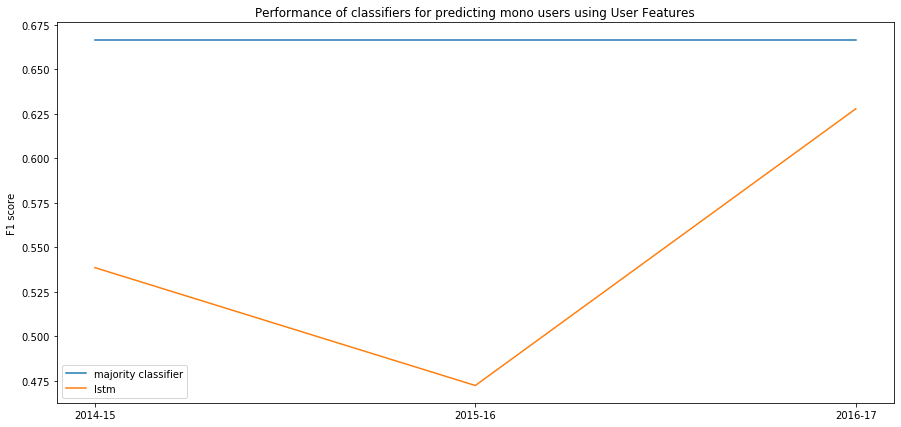

In [290]:
y_pred_maj = [0 for x in range(len(Y_test))]
maj_score = precision_recall_fscore_support(Y_test,y_pred_maj,average=None)[2][0]

lstm = [ele[0] for ele in lstm_scores]

## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
plt.plot(years,3*[maj_score],label="majority classifier")
plt.plot(years,lstm,label="lstm")
plt.title("Performance of classifiers for predicting mono users using User Features")
plt.ylabel("F1 score")
plt.legend()
plt.show()

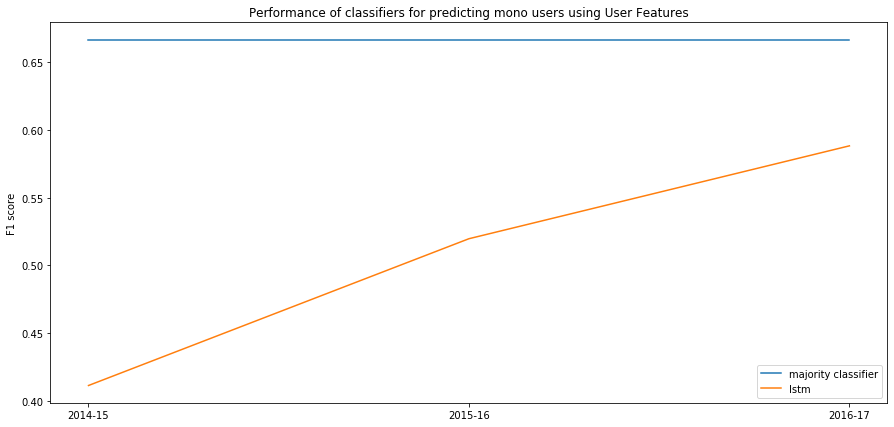

In [291]:
y_pred_maj = [1 for x in range(len(Y_test))]
maj_score = precision_recall_fscore_support(Y_test,y_pred_maj,average=None)[2][1]

lstm = [ele[1] for ele in lstm_scores]

## plotting user features
plt.figure(figsize=(15,7))
years = ["2014-15","2015-16","2016-17"]
plt.plot(years,3*[maj_score],label="majority classifier")
plt.plot(years,lstm,label="lstm")
plt.title("Performance of classifiers for predicting mono users using User Features")
plt.ylabel("F1 score")
plt.legend()
plt.show()